Dataset loaded successfully.
Shape: (550, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Campaign_ID  550 non-null    object 
 1   Channel      550 non-null    object 
 2   Impressions  534 non-null    float64
 3   Clicks       534 non-null    float64
 4   Conversions  534 non-null    float64
 5   Cost         534 non-null    float64
 6   Revenue      534 non-null    float64
 7   Region       550 non-null    object 
 8   Date         550 non-null    object 
dtypes: float64(5), object(4)
memory usage: 38.8+ KB
Missing values before handling:
Campaign_ID     0
Channel         0
Impressions    16
Clicks         16
Conversions    16
Cost           16
Revenue        16
Region          0
Date            0
dtype: int64
Filled NaN in 'Impressions' with median value: 32683.00
Filled NaN in 'Clicks' with median value: 718.00
Filled NaN in 'Conversio

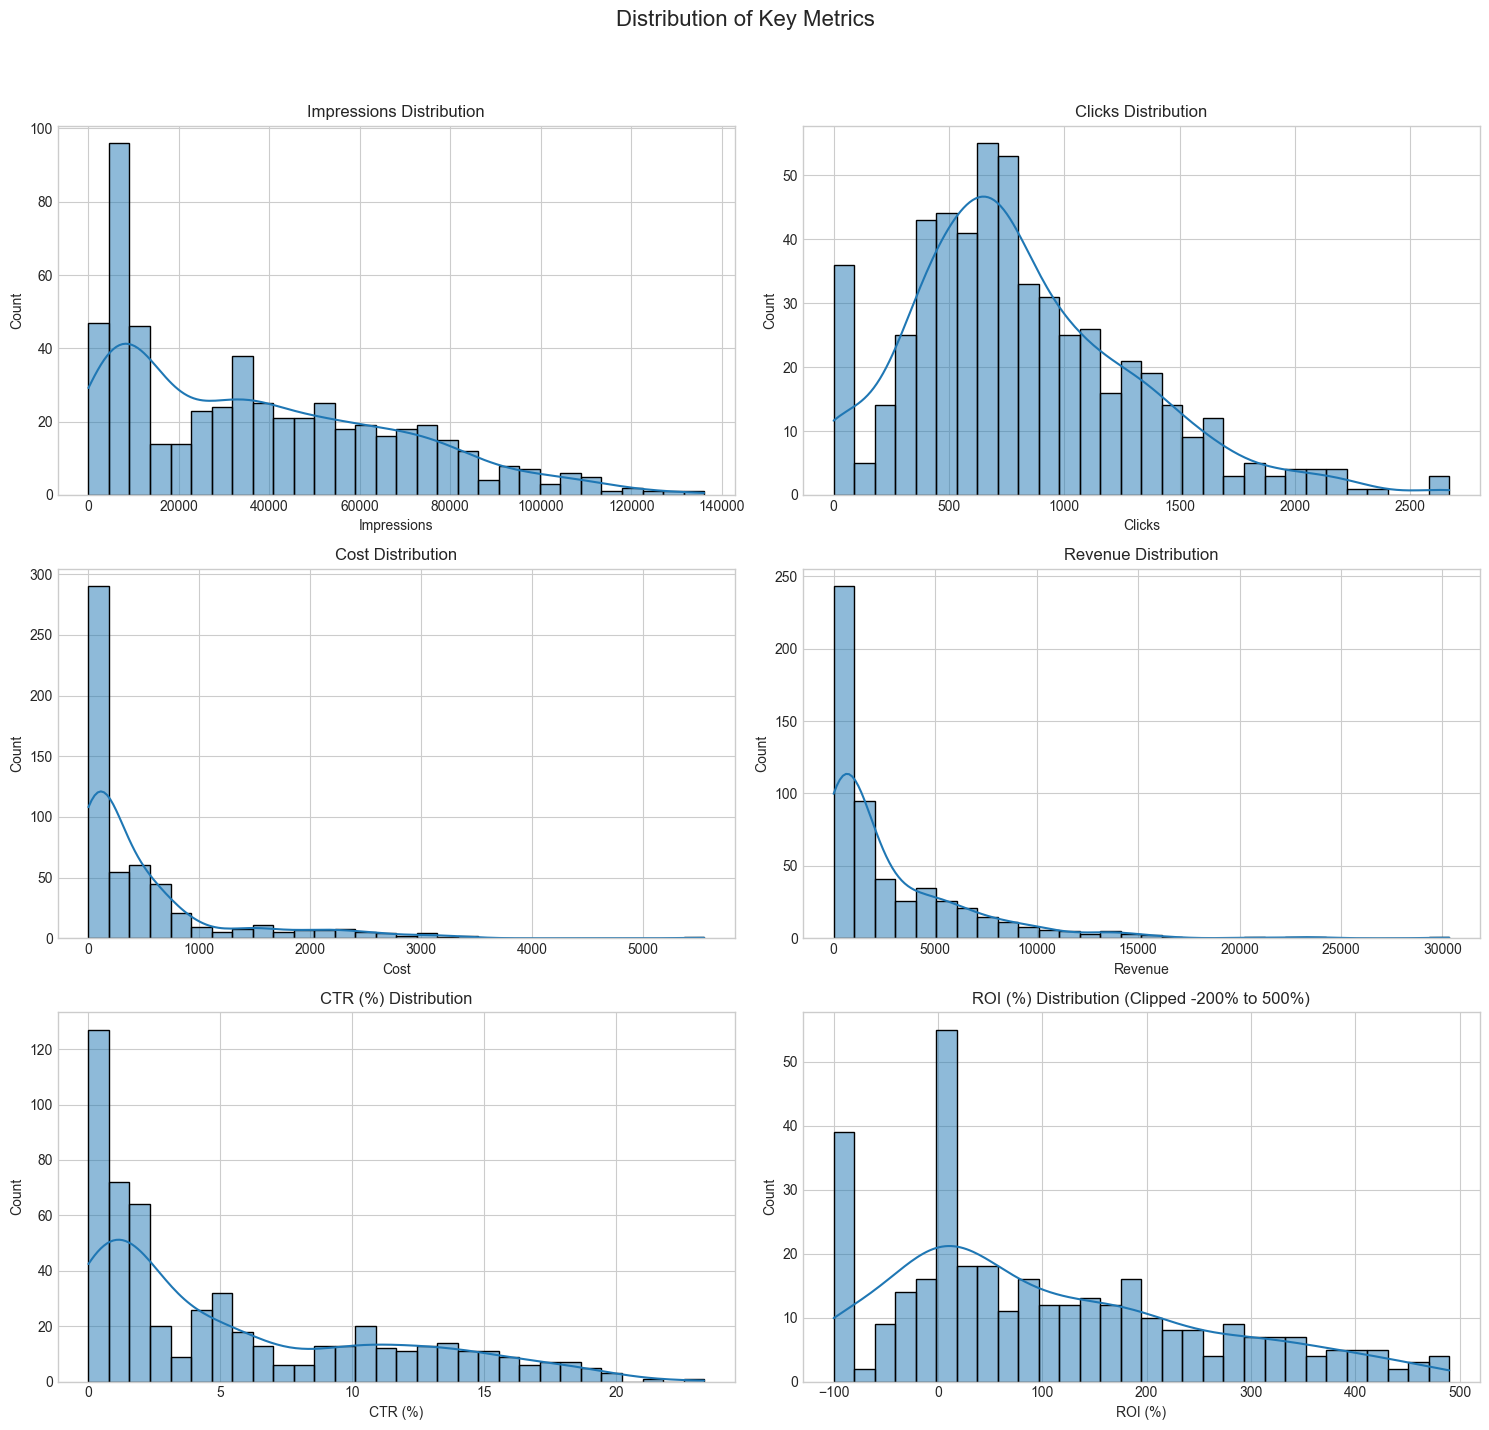


--- Performance by Channel ---
               Total_Revenue  Total_Cost  Total_Impressions  Total_Clicks  \
Channel                                                                     
Search Engine      724939.34   160565.47         2968513.00     128290.00   
Referral           439671.45     3728.94          595435.00      73950.00   
Email              208621.29     8353.08          944467.00      80470.00   
Social Media       113748.40    42106.96         4490357.00      85340.00   
Video Ads           51441.03    39409.78         5293455.00      48179.00   
Display Ads         17554.78     9142.95         6414048.00      29516.00   

               Total_Conversions  Average_CTR  Average_CPC  \
Channel                                                      
Search Engine            8774.00         4.42         1.16   
Referral                 6517.00        13.64         0.05   
Email                    3505.00         9.08         0.11   
Social Media             2308.00         

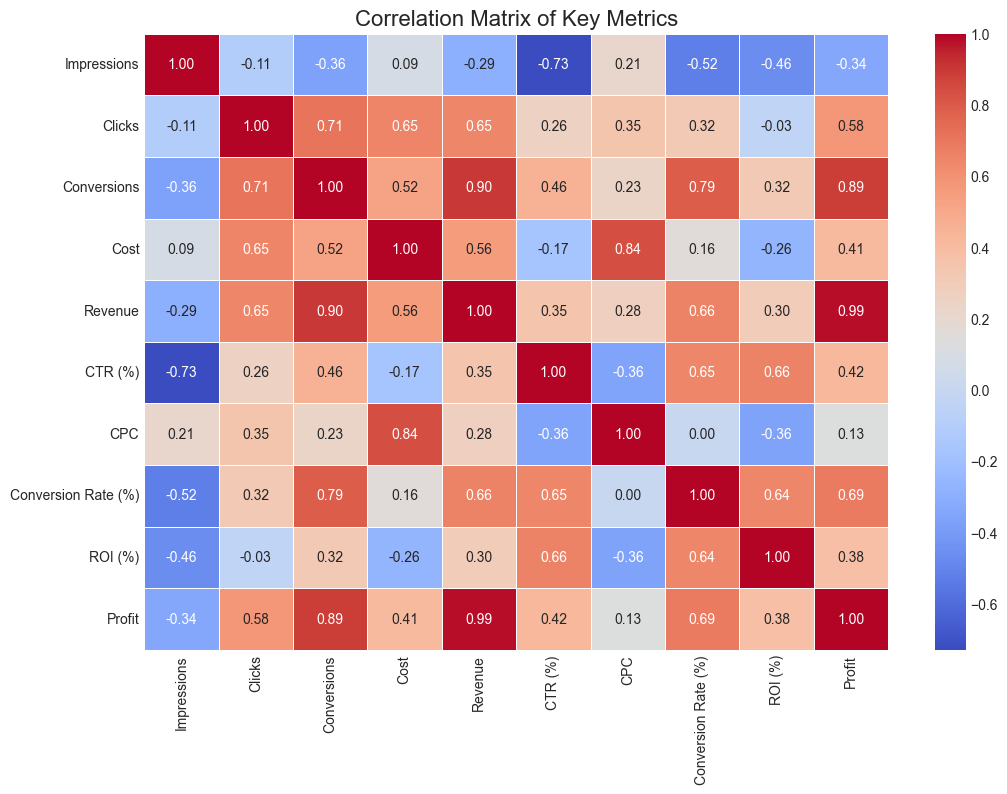

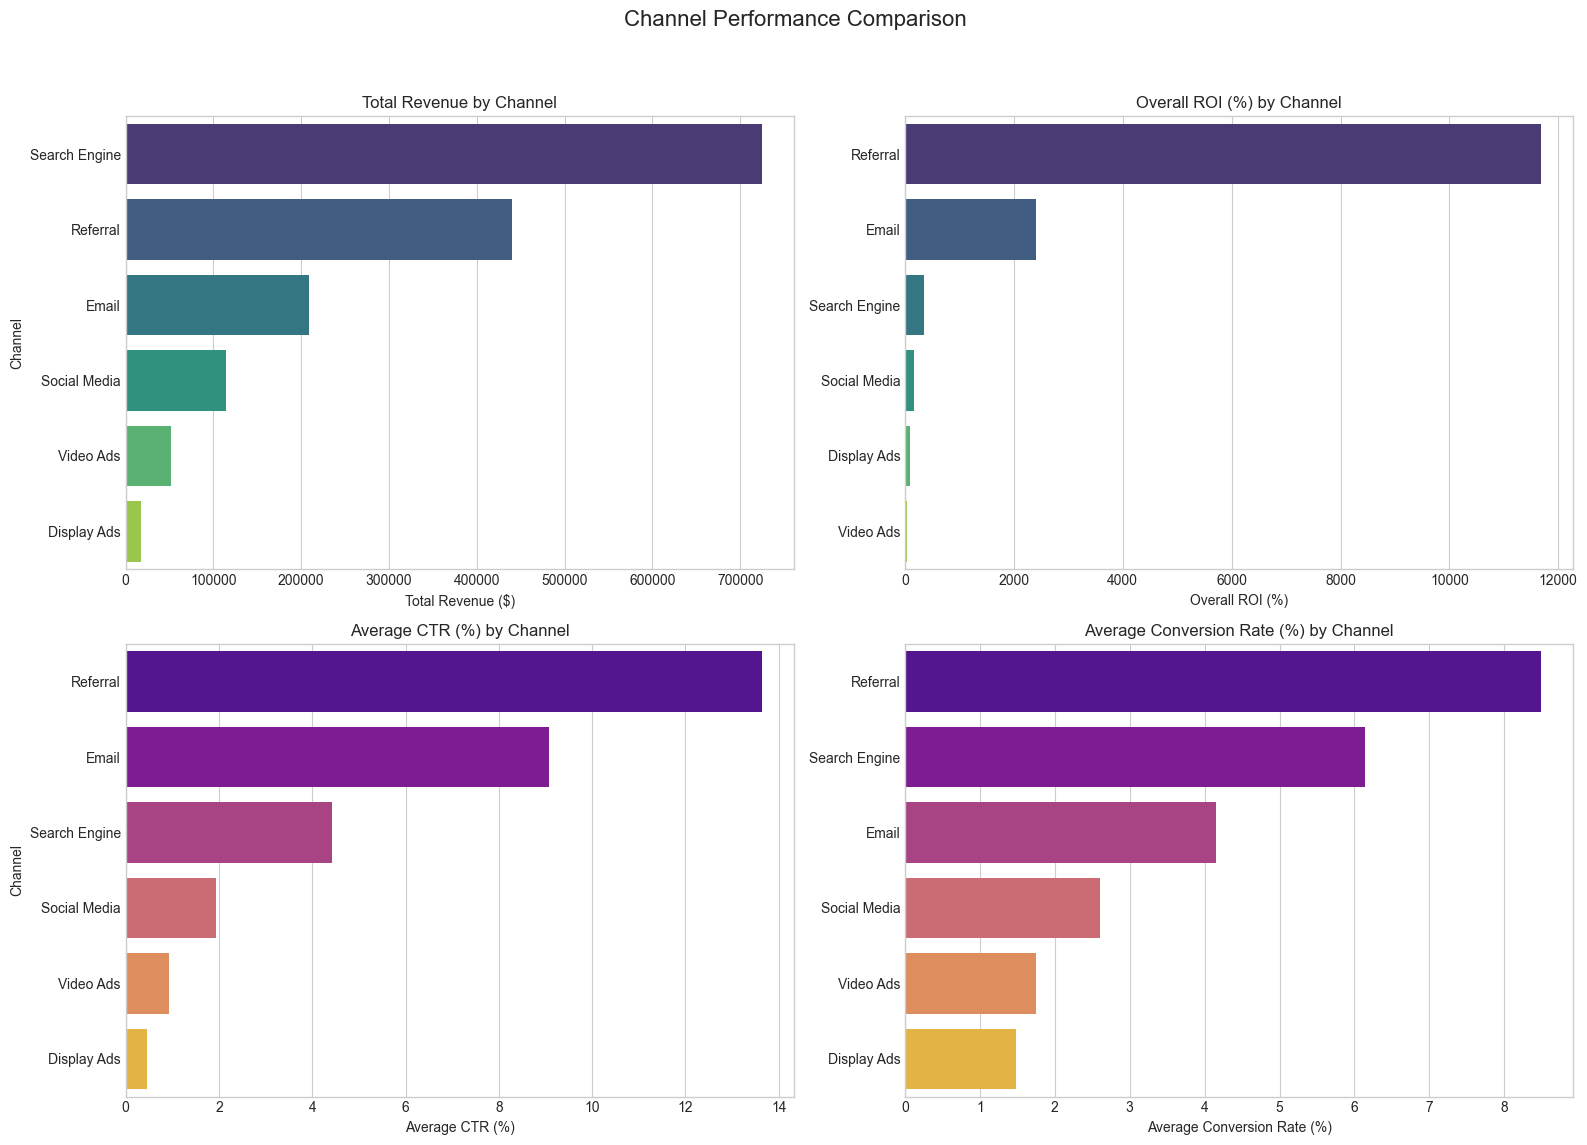

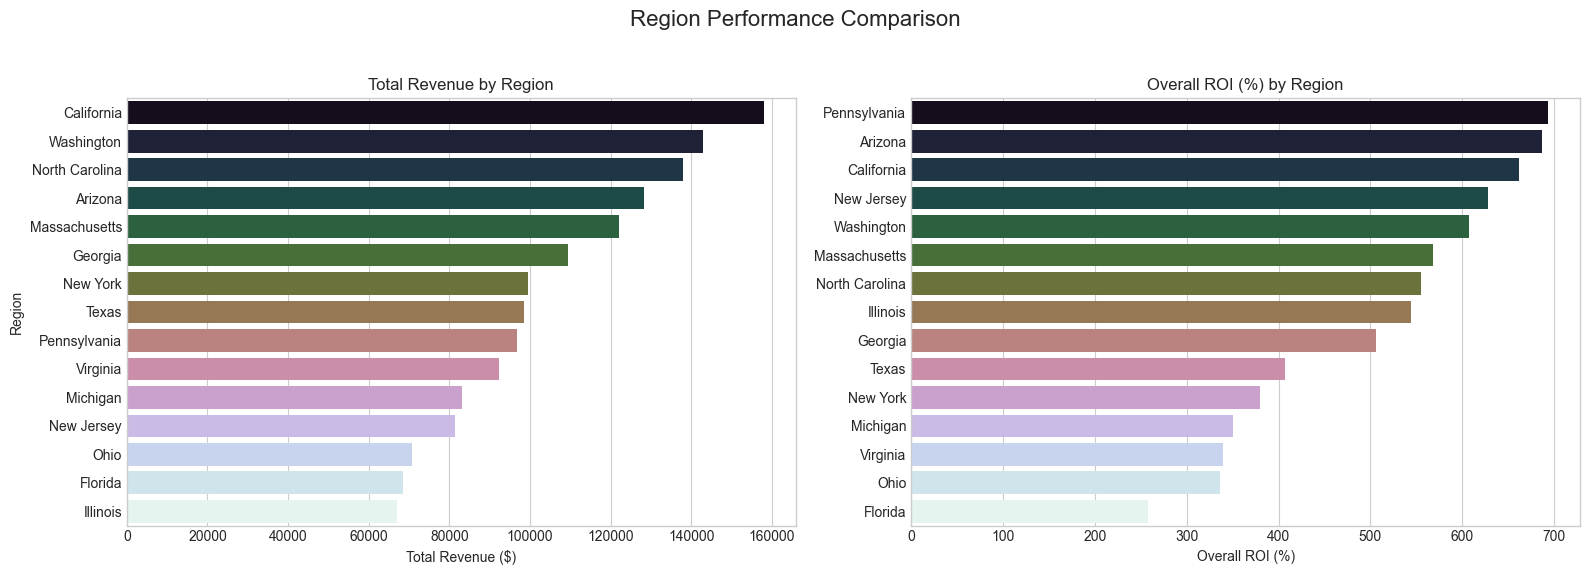

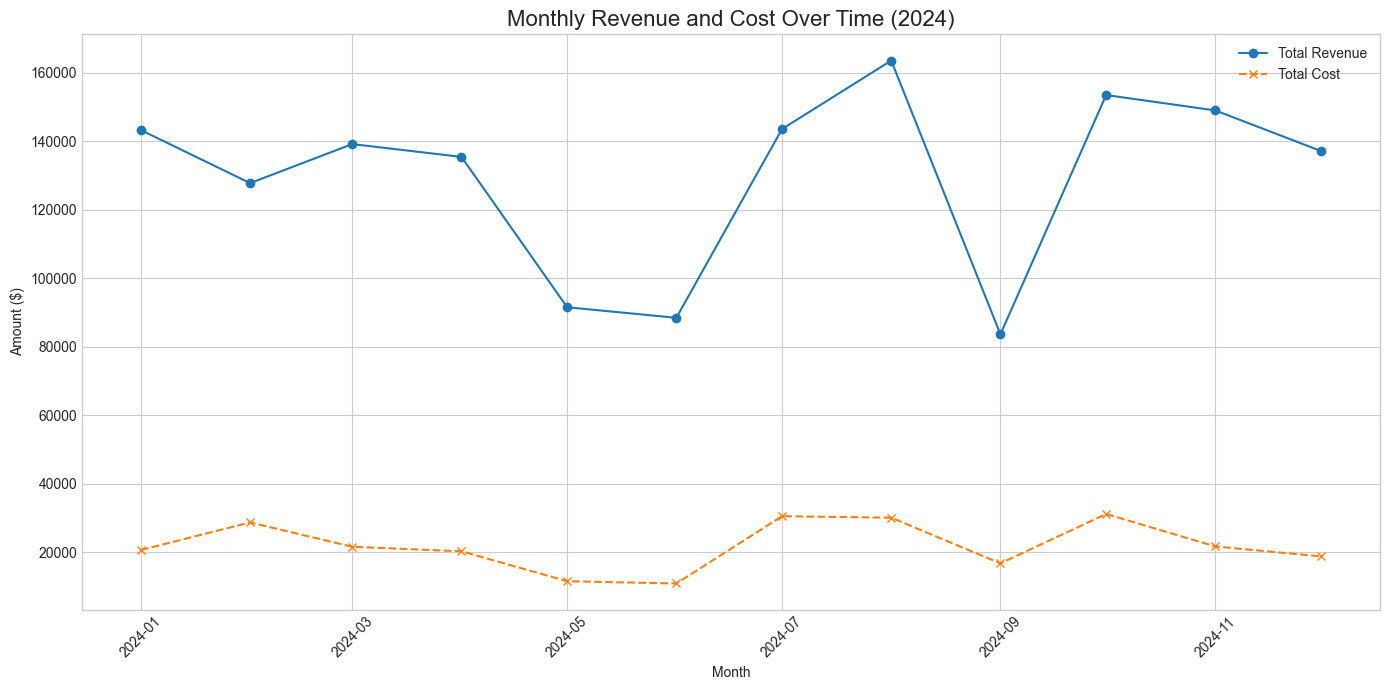

Training set size: 440 samples
Test set size: 110 samples

--- Model Performance Evaluation ---
--- Linear Regression Evaluation ---
 R-squared (R2): 0.602
 Mean Absolute Error (MAE): 1972.169
 Mean Squared Error (MSE): 18301480.283
 Root Mean Squared Error (RMSE): 4278.023
-----------------------------------
--- Random Forest Regressor Evaluation ---
 R-squared (R2): 0.662
 Mean Absolute Error (MAE): 1509.822
 Mean Squared Error (MSE): 15535579.909
 Root Mean Squared Error (RMSE): 3941.520
-----------------------------------------


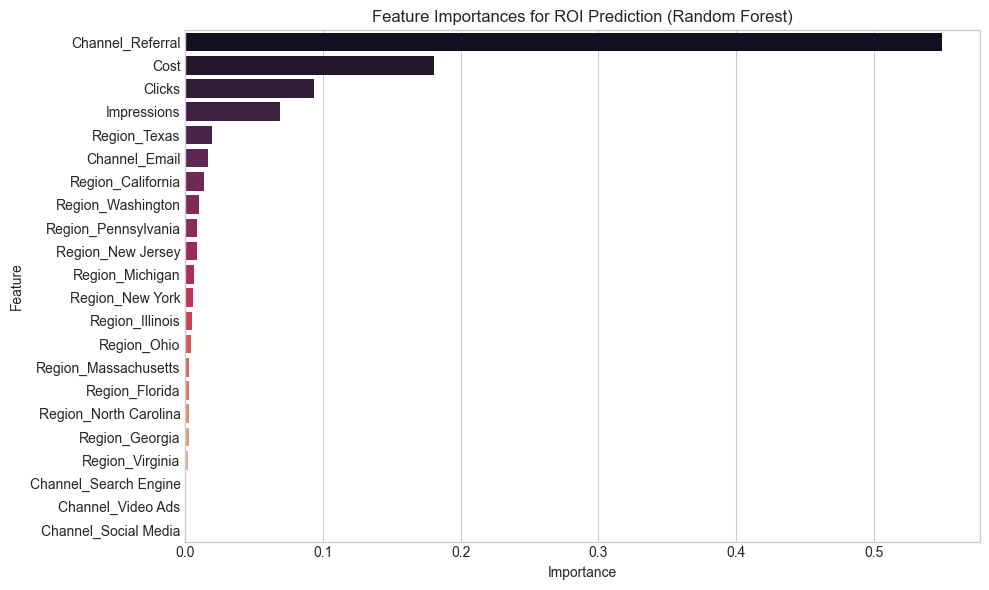


--- Feature Importances (Random Forest) ---
                  Feature  Importance
4        Channel_Referral        0.55
2                    Cost        0.18
1                  Clicks        0.09
0             Impressions        0.07
19           Region_Texas        0.02
3           Channel_Email        0.02
8       Region_California        0.01
21      Region_Washington        0.01
18    Region_Pennsylvania        0.01
14      Region_New Jersey        0.01
13        Region_Michigan        0.01
15        Region_New York        0.01
11        Region_Illinois        0.01
17            Region_Ohio        0.00
12   Region_Massachusetts        0.00
9          Region_Florida        0.00
16  Region_North Carolina        0.00
10         Region_Georgia        0.00
20        Region_Virginia        0.00
5   Channel_Search Engine        0.00
7       Channel_Video Ads        0.00
6    Channel_Social Media        0.00

Cleaned and enriched dataset saved to 'marketing_campaign_data_cleaned.csv'
  Ca

In [3]:
# -*- coding: utf-8 -*-
"""
Marketing Campaign Analysis Project

This notebook performs analysis on synthetic marketing campaign data.
Steps include:
1. Load Data
2. Clean and Preprocess Data
3. Feature Engineering (CTR, CPC, Conversion Rate, ROI)
4. Exploratory Data Analysis (EDA)
5. Visualization
6. (Optional) Predictive Modeling
7. Save Cleaned Data
"""

# %% [markdown]
# ## 1. Load Data

# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output
pd.set_option('display.float_format', lambda x: '%.2f' % x) # Nicer float formatting

# %%
# Load the raw dataset generated previously
try:
    df_raw = pd.read_csv('marketing_campaign_data_raw.csv')
    print("Dataset loaded successfully.")
    print(f"Shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: marketing_campaign_data_raw.csv not found.")
    print("Please run the data generation script first.")
    # Exit or handle error appropriately in a real script
    exit() # In a notebook, you might just stop execution here

# %%
df_raw.head()

# %%
df_raw.info()

# %% [markdown]
# ## 2. Clean and Preprocess Data

# %%
# Create a copy for cleaning to preserve the raw data
df = df_raw.copy()

# Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'])

# Check for missing values
print("Missing values before handling:")
print(df.isnull().sum())

# %%
# Handle missing values
# Strategy: Impute numerical with median, as it's less sensitive to outliers than mean.
# For this dataset, 0 is a plausible value for metrics like Conversions/Revenue if Clicks=0,
# but median imputation is safer for randomly introduced NaNs.
cols_to_impute = ['Impressions', 'Clicks', 'Conversions', 'Cost', 'Revenue']
for col in cols_to_impute:
    median_val = df[col].median()
    df[col].fillna(median_val, inplace=True)
    print(f"Filled NaN in '{col}' with median value: {median_val:.2f}")

# Verify missing values are handled
print("\nMissing values after handling:")
print(df.isnull().sum())


# %%
# Check for duplicate rows
duplicates = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicates}")
if duplicates > 0:
    df.drop_duplicates(inplace=True)
    print(f"Dropped duplicates. New shape: {df.shape}")

# %%
# Check for illogical data
print("\nChecking for Clicks > Impressions:")
print(f"Rows where Clicks > Impressions: {len(df[df['Clicks'] > df['Impressions']])}")
# Correct if found (though generation logic tries to prevent this)
df['Clicks'] = df.apply(lambda row: min(row['Clicks'], row['Impressions']) if pd.notnull(row['Clicks']) and pd.notnull(row['Impressions']) else row['Clicks'], axis=1)

print("\nChecking for Conversions > Clicks:")
print(f"Rows where Conversions > Clicks: {len(df[df['Conversions'] > df['Clicks']])}")
# Correct if found
df['Conversions'] = df.apply(lambda row: min(row['Conversions'], row['Clicks']) if pd.notnull(row['Conversions']) and pd.notnull(row['Clicks']) else row['Conversions'], axis=1)


# Ensure non-negative values for metrics where applicable (should be fine with generation logic)
numeric_cols = ['Impressions', 'Clicks', 'Conversions', 'Cost', 'Revenue']
for col in numeric_cols:
    df[col] = df[col].apply(lambda x: max(0, x) if pd.notnull(x) else 0) # Set negative values to 0


print("\nData cleaning and basic preprocessing complete.")
df.info()
df.describe()


# %% [markdown]
# ## 3. Feature Engineering

# %%
# Calculate Key Performance Indicators (KPIs)

# Click-Through Rate (CTR) = (Clicks / Impressions) * 100
# Handle division by zero: if Impressions is 0, CTR is 0.
df['CTR (%)'] = np.where(df['Impressions'] > 0, (df['Clicks'] / df['Impressions']) * 100, 0)

# Cost Per Click (CPC) = Cost / Clicks
# Handle division by zero: if Clicks is 0, CPC can be considered 0 or infinity. Let's use 0 for simplicity in aggregation.
df['CPC'] = np.where(df['Clicks'] > 0, df['Cost'] / df['Clicks'], 0)

# Conversion Rate (CR) = (Conversions / Clicks) * 100
# Handle division by zero: if Clicks is 0, CR is 0.
df['Conversion Rate (%)'] = np.where(df['Clicks'] > 0, (df['Conversions'] / df['Clicks']) * 100, 0)

# Return on Investment (ROI) = ((Revenue - Cost) / Cost) * 100
# Handle division by zero: if Cost is 0:
#   - If Revenue is also 0, ROI is 0% (or undefined). Let's use 0.
#   - If Revenue > 0, ROI is technically infinite. Let's cap it or assign a large value/NaN. For dashboarding, maybe 0 or analyze separately. Using 0 here.
df['Profit'] = df['Revenue'] - df['Cost']
df['ROI (%)'] = np.where(df['Cost'] > 0, (df['Profit'] / df['Cost']) * 100, 0)
# Alternative: Set ROI to NaN or a very high number if Cost=0 and Revenue>0
# df['ROI (%)'] = np.where(df['Cost'] > 0, (df['Profit'] / df['Cost']) * 100, np.where(df['Revenue'] > 0, np.inf, 0))


# Extract time features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek # Monday=0, Sunday=6
df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)


print("Feature engineering complete. Added CTR, CPC, Conversion Rate, ROI, Profit, and Time Features.")
df.head()

# %%
df.describe()

# %% [markdown]
# ## 4. Exploratory Data Analysis (EDA)

# %% [markdown]
# ### Overall Performance Metrics

# %%
total_revenue = df['Revenue'].sum()
total_cost = df['Cost'].sum()
total_profit = df['Profit'].sum()
overall_roi = (total_profit / total_cost) * 100 if total_cost > 0 else 0
avg_ctr = df['CTR (%)'].mean()
avg_conv_rate = df['Conversion Rate (%)'].mean()

print("--- Overall Campaign Performance ---")
print(f"Total Revenue: ${total_revenue:,.2f}")
print(f"Total Cost: ${total_cost:,.2f}")
print(f"Total Profit: ${total_profit:,.2f}")
print(f"Overall ROI: {overall_roi:.2f}%")
print(f"Average CTR: {avg_ctr:.2f}%")
print(f"Average Conversion Rate: {avg_conv_rate:.2f}%")


# %% [markdown]
# ### Distribution of Key Metrics

# %%
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Distribution of Key Metrics', fontsize=16)

sns.histplot(df['Impressions'], kde=True, ax=axes[0, 0], bins=30).set_title('Impressions Distribution')
sns.histplot(df['Clicks'], kde=True, ax=axes[0, 1], bins=30).set_title('Clicks Distribution')
sns.histplot(df['Cost'], kde=True, ax=axes[1, 0], bins=30).set_title('Cost Distribution')
sns.histplot(df['Revenue'], kde=True, ax=axes[1, 1], bins=30).set_title('Revenue Distribution')
sns.histplot(df['CTR (%)'], kde=True, ax=axes[2, 0], bins=30).set_title('CTR (%) Distribution')
# ROI can have extreme values, consider clipping or log scale if needed
sns.histplot(df[df['ROI (%)'].between(-200, 500)]['ROI (%)'], kde=True, ax=axes[2, 1], bins=30).set_title('ROI (%) Distribution (Clipped -200% to 500%)')


plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.show()

# %% [markdown]
# ### Performance by Channel

# %%
# Group by channel and calculate aggregate/average metrics
channel_performance = df.groupby('Channel').agg(
    Total_Revenue=('Revenue', 'sum'),
    Total_Cost=('Cost', 'sum'),
    Total_Impressions=('Impressions', 'sum'),
    Total_Clicks=('Clicks', 'sum'),
    Total_Conversions=('Conversions', 'sum'),
    Average_CTR=('CTR (%)', 'mean'),
    Average_CPC=('CPC', 'mean'),
    Average_Conversion_Rate=('Conversion Rate (%)', 'mean'),
    Average_ROI=('ROI (%)', 'mean')
).sort_values(by='Total_Revenue', ascending=False)

# Calculate overall ROI per channel
channel_performance['Overall_ROI (%)'] = np.where(
    channel_performance['Total_Cost'] > 0,
    ((channel_performance['Total_Revenue'] - channel_performance['Total_Cost']) / channel_performance['Total_Cost']) * 100,
    0
)

print("\n--- Performance by Channel ---")
print(channel_performance)


# %% [markdown]
# ### Performance by Region

# %%
# Group by region
region_performance = df.groupby('Region').agg(
    Total_Revenue=('Revenue', 'sum'),
    Total_Cost=('Cost', 'sum'),
    Average_ROI=('ROI (%)', 'mean'),
    Total_Conversions=('Conversions', 'sum')
).sort_values(by='Total_Revenue', ascending=False)

# Calculate overall ROI per region
region_performance['Overall_ROI (%)'] = np.where(
    region_performance['Total_Cost'] > 0,
    ((region_performance['Total_Revenue'] - region_performance['Total_Cost']) / region_performance['Total_Cost']) * 100,
    0
)


print("\n--- Performance by Region ---")
print(region_performance)


# %% [markdown]
# ### Performance Over Time

# %%
# Group by month
monthly_performance = df.groupby(['Year', 'Month']).agg(
    Monthly_Revenue=('Revenue', 'sum'),
    Monthly_Cost=('Cost', 'sum'),
    Monthly_Clicks=('Clicks', 'sum'),
    Monthly_Conversions=('Conversions', 'sum')
).reset_index()

# Create a proper date for plotting monthly trends
monthly_performance['Month_Date'] = pd.to_datetime(monthly_performance[['Year', 'Month']].assign(day=1))

print("\n--- Monthly Performance Trends ---")
print(monthly_performance.head())


# %% [markdown]
# ### Correlation Analysis

# %%
# Select numerical features for correlation matrix
correlation_features = ['Impressions', 'Clicks', 'Conversions', 'Cost', 'Revenue', 'CTR (%)', 'CPC', 'Conversion Rate (%)', 'ROI (%)', 'Profit']
correlation_matrix = df[correlation_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Key Metrics', fontsize=16)
plt.show()

# %% [markdown]
# ## 5. Visualization

# %% [markdown]
# ### Channel Performance Visuals

# %%
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Channel Performance Comparison', fontsize=16)

# Sort for better visualization
channel_perf_sorted_roi = channel_performance.sort_values('Overall_ROI (%)', ascending=False)
channel_perf_sorted_ctr = channel_performance.sort_values('Average_CTR', ascending=False)
channel_perf_sorted_conv = channel_performance.sort_values('Average_Conversion_Rate', ascending=False)
channel_perf_sorted_rev = channel_performance.sort_values('Total_Revenue', ascending=False)


sns.barplot(x=channel_perf_sorted_rev['Total_Revenue'], y=channel_perf_sorted_rev.index, ax=axes[0, 0], palette='viridis').set_title('Total Revenue by Channel')
axes[0, 0].set_xlabel("Total Revenue ($)")
axes[0, 0].set_ylabel("Channel")


sns.barplot(x=channel_perf_sorted_roi['Overall_ROI (%)'], y=channel_perf_sorted_roi.index, ax=axes[0, 1], palette='viridis').set_title('Overall ROI (%) by Channel')
axes[0, 1].set_xlabel("Overall ROI (%)")
axes[0, 1].set_ylabel("")


sns.barplot(x=channel_perf_sorted_ctr['Average_CTR'], y=channel_perf_sorted_ctr.index, ax=axes[1, 0], palette='plasma').set_title('Average CTR (%) by Channel')
axes[1, 0].set_xlabel("Average CTR (%)")
axes[1, 0].set_ylabel("Channel")


sns.barplot(x=channel_perf_sorted_conv['Average_Conversion_Rate'], y=channel_perf_sorted_conv.index, ax=axes[1, 1], palette='plasma').set_title('Average Conversion Rate (%) by Channel')
axes[1, 1].set_xlabel("Average Conversion Rate (%)")
axes[1, 1].set_ylabel("")


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# %% [markdown]
# ### Region Performance Visuals

# %%
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Region Performance Comparison', fontsize=16)

region_perf_sorted_rev = region_performance.sort_values('Total_Revenue', ascending=False)
region_perf_sorted_roi = region_performance.sort_values('Overall_ROI (%)', ascending=False)


sns.barplot(x=region_perf_sorted_rev['Total_Revenue'], y=region_perf_sorted_rev.index, ax=axes[0], palette='cubehelix').set_title('Total Revenue by Region')
axes[0].set_xlabel("Total Revenue ($)")
axes[0].set_ylabel("Region")

sns.barplot(x=region_perf_sorted_roi['Overall_ROI (%)'], y=region_perf_sorted_roi.index, ax=axes[1], palette='cubehelix').set_title('Overall ROI (%) by Region')
axes[1].set_xlabel("Overall ROI (%)")
axes[1].set_ylabel("")


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# %% [markdown]
# ### Time Series Performance Visuals

# %%
plt.figure(figsize=(14, 7))
plt.plot(monthly_performance['Month_Date'], monthly_performance['Monthly_Revenue'], label='Total Revenue', marker='o', linestyle='-')
plt.plot(monthly_performance['Month_Date'], monthly_performance['Monthly_Cost'], label='Total Cost', marker='x', linestyle='--')
plt.title('Monthly Revenue and Cost Over Time (2024)', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Amount ($)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# %% [markdown]
# ## 6. (Optional) Predictive Modeling - Predict ROI

# %% [markdown]
# Let's try to predict ROI based on other campaign features. This is a simplified example.
# *Note: Predicting ROI can be tricky due to its calculation involving Cost in the denominator. Predicting Revenue or Conversions might be more robust.*

# %%
# Prepare data for modeling
# Select features (using a subset for simplicity)
features = ['Impressions', 'Clicks', 'Cost', 'Channel', 'Region']
target = 'ROI (%)'

# Handle categorical features using one-hot encoding
df_model = pd.get_dummies(df[features + [target]], columns=['Channel', 'Region'], drop_first=True)

# Remove outliers or infinite values in ROI if they exist (we capped it at 0 for Cost=0 case earlier)
# Handle potential infinite values if the alternative ROI calculation was used
df_model = df_model.replace([np.inf, -np.inf], np.nan)
df_model.dropna(subset=[target], inplace=True) # Drop rows where target is NaN

# Define X (features) and y (target)
X = df_model.drop(target, axis=1)
y = df_model[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")


# %%
# Train a simple Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Train a RandomForest Regressor model (often performs better)
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)


# %%
# Make predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate models
def evaluate_model(y_true, y_pred, model_name="Model"):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"--- {model_name} Evaluation ---")
    print(f" R-squared (R2): {r2:.3f}")
    print(f" Mean Absolute Error (MAE): {mae:.3f}")
    print(f" Mean Squared Error (MSE): {mse:.3f}")
    print(f" Root Mean Squared Error (RMSE): {rmse:.3f}")
    print("-"*(len(model_name)+18))
    return r2, mae, rmse

print("\n--- Model Performance Evaluation ---")
lr_r2, lr_mae, lr_rmse = evaluate_model(y_test, y_pred_lr, "Linear Regression")
rf_r2, rf_mae, rf_rmse = evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")


# %%
# Feature Importance (from Random Forest)
if hasattr(rf_model, 'feature_importances_'):
    importances = rf_model.feature_importances_
    feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='rocket')
    plt.title('Feature Importances for ROI Prediction (Random Forest)')
    plt.tight_layout()
    plt.show()
    
    print("\n--- Feature Importances (Random Forest) ---")
    print(importance_df)


# %% [markdown]
# ## 7. Save Cleaned Data for Dashboarding

# %%
# Select relevant columns for the dashboard
dashboard_cols = [
    'Campaign_ID', 'Channel', 'Impressions', 'Clicks', 'Conversions', 'Cost',
    'Revenue', 'Region', 'Date', 'CTR (%)', 'CPC', 'Conversion Rate (%)',
    'ROI (%)', 'Profit', 'Year', 'Month', 'DayOfWeek', 'WeekOfYear'
]
df_cleaned = df[dashboard_cols]

# Save the cleaned and enriched data to a new CSV file
cleaned_file_path = 'marketing_campaign_data_cleaned.csv'
df_cleaned.to_csv(cleaned_file_path, index=False, date_format='%Y-%m-%d')

print(f"\nCleaned and enriched dataset saved to '{cleaned_file_path}'")
print(df_cleaned.head())